# 🤖 Modelagem Preditiva - Desmatamento na Amazônia
## Desafio 2 - Ciência e Governança de Dados

---

### Objetivos:
- Treinar múltiplos modelos de Machine Learning usando scikit-learn
- Comparar performance dos modelos
- Otimizar hiperparâmetros
- Fazer predições de desmatamento futuro
- Analisar importância das features
- Salvar modelo final

In [1]:
# Importações
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from src.data_processing import DataProcessor
from src.modeling import ModelTrainer
from src.visualization import DataVisualizer

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 1️⃣ Carregamento dos Dados Processados

In [2]:
# Inicializa componentes
processor = DataProcessor(base_path='../data')
trainer = ModelTrainer(model_path='../models')
visualizer = DataVisualizer()

# Carrega dados processados (com features engenhadas)
df = pd.read_csv('../data/processed/base_final_engineered.csv')

print(f"📦 Shape dos dados: {df.shape}")
print(f"📅 Período: {df['ano'].min():.0f} - {df['ano'].max():.0f}")
print(f"🗺️ Estados: {df['UF'].nunique()}")

df.head()

📦 Shape dos dados: (90, 38)
📅 Período: 2012 - 2021
🗺️ Estados: 9


,UF,ano,populacao,pib_mil_reais,pib_bilhoes,IDH,desmatamento_km2,ano_categorico,ano_normalizado,decada,desmatamento_km2_growth_rate,pib_bilhoes_growth_rate,populacao_growth_rate,IDH_growth_rate,desmatamento_lag1,desmatamento_lag2,pib_lag1,idh_lag1,desmatamento_ma3,desmatamento_std3,pib_ma3,pib_per_capita,desmatamento_per_capita,intensidade_desmatamento,idh_ajustado,categoria_idh,categoria_desmatamento,periodo,desmatamento_km2_mean,desmatamento_km2_std,desmatamento_desvio_estado,desmatamento_zscore_estado,desmatamento_km2_normalized,pib_bilhoes_normalized,populacao_normalized,pib_x_populacao,idh_x_pib,ano_x_pib
0,AC,2012,758786,10137925.0000,10.1400,0.7010,270.5973,2012,0.0000,2010,-26.0007,0.0000,0.0000,0.0000,270.5973,270.5973,10.1400,0.7010,270.5973,49.7501,10.1400,13363.4516,356.6187,26.6861,0.5517,Alto,Médio,Primeira_Metade,631.4456,935.1311,-360.8483,-0.3859,0.0146,0.0095,0.0348,7694090.0400,7.1081,20401.6800
1,AC,2013,776463,11473929.0000,11.4700,0.7060,200.2401,2013,0.1111,2010,-26.0007,13.1164,2.3296,0.7133,270.5973,270.5973,10.1400,0.7010,235.4187,49.7501,10.8050,14772.1141,257.8875,17.4577,0.5882,Alto,Médio,Primeira_Metade,631.4456,935.1311,-431.2055,-0.4611,0.0107,0.0147,0.0369,8906030.6100,8.0978,23089.1100
2,AC,2014,790101,13458696.0000,13.4600,0.7150,348.6096,2014,0.2222,2010,74.0958,17.3496,1.7564,1.2748,200.2401,270.5973,11.4700,0.7060,273.1490,74.2177,11.6900,17035.7967,441.2215,25.8997,0.5302,Alto,Médio,Primeira_Metade,631.4456,935.1311,-282.8360,-0.3025,0.0188,0.0225,0.0386,10634759.4600,9.6239,27108.4400
3,AC,2015,803513,13622803.0000,13.6200,0.7180,223.0037,2015,0.3333,2010,-36.0305,1.1887,1.6975,0.4196,348.6096,200.2401,13.4600,0.7150,257.2845,79.9046,12.8500,16950.5658,277.5359,16.3733,0.5871,Alto,Médio,Primeira_Metade,631.4456,935.1311,-408.4418,-0.4368,0.0120,0.0232,0.0402,10943847.0600,9.7792,27444.3000
4,AC,2016,816687,13754242.0000,13.7500,0.7230,366.3338,2016,0.4444,2010,64.2725,0.9545,1.6396,0.6964,223.0037,348.6096,13.6200,0.7180,312.6490,78.1393,13.6100,16836.3155,448.5608,26.6425,0.5292,Alto,Médio,Primeira_Metade,631.4456,935.1311,-265.1118,-0.2835,0.0198,0.0237,0.0418,11229446.2500,9.9413,27720.0000


## 2️⃣ Seleção de Features para Modelagem

In [3]:
# Define variável alvo
target = 'desmatamento_km2'

# Seleciona features mais relevantes
features_selecionadas = [
    # Features originais
    'ano',
    'populacao',
    'pib_bilhoes',
    'IDH',
    
    # Features temporais
    'ano_normalizado',
    
    # Features de lag
    'desmatamento_lag1',
    'pib_lag1',
    'idh_lag1',
    
    # Rolling statistics
    'desmatamento_ma3',
    'pib_ma3',
    
    # Features derivadas
    'pib_per_capita',
    'desmatamento_per_capita',
    'intensidade_desmatamento',
    
    # Features de crescimento
    'pib_bilhoes_growth_rate',
    'populacao_growth_rate',
    
    # Features de agregação
    'desmatamento_km2_mean',
    'desmatamento_desvio_estado'
]

print(f"🎯 Variável Alvo: {target}")
print(f"📊 Features Selecionadas: {len(features_selecionadas)}")
print("\nLista de Features:")
for i, feature in enumerate(features_selecionadas, 1):
    print(f"  {i:2d}. {feature}")

🎯 Variável Alvo: desmatamento_km2
📊 Features Selecionadas: 17

Lista de Features:
   1. ano
   2. populacao
   3. pib_bilhoes
   4. IDH
   5. ano_normalizado
   6. desmatamento_lag1
   7. pib_lag1
   8. idh_lag1
   9. desmatamento_ma3
  10. pib_ma3
  11. pib_per_capita
  12. desmatamento_per_capita
  13. intensidade_desmatamento
  14. pib_bilhoes_growth_rate
  15. populacao_growth_rate
  16. desmatamento_km2_mean
  17. desmatamento_desvio_estado


## 3️⃣ Preparação dos Dados (Train/Test Split)

In [4]:
# Prepara dados para modelagem
X_train, X_test, y_train, y_test = trainer.prepare_data(
    df=df,
    target=target,
    features=features_selecionadas,
    test_size=0.2,
    random_state=42,
    scale=True
)

print("📦 Divisão dos Dados:")
print("="*60)
print(f"✅ Conjunto de Treino: {X_train.shape[0]} amostras")
print(f"✅ Conjunto de Teste:  {X_test.shape[0]} amostras")
print(f"\n📊 Features: {X_train.shape[1]}")
print(f"\n📈 Estatísticas do Target (Treino):")
print(f"   Média: {y_train.mean():.2f} km²")
print(f"   Desvio Padrão: {y_train.std():.2f} km²")
print(f"   Mínimo: {y_train.min():.2f} km²")
print(f"   Máximo: {y_train.max():.2f} km²")

📦 Divisão dos Dados:
✅ Conjunto de Treino: 72 amostras
✅ Conjunto de Teste:  18 amostras

📊 Features: 17

📈 Estatísticas do Target (Treino):
   Média: 1425.20 km²
   Desvio Padrão: 2779.35 km²
   Mínimo: 3.30 km²
   Máximo: 18328.02 km²


## 4️⃣ Treinamento de Múltiplos Modelos

In [5]:
# Treina e compara múltiplos modelos
print("🚀 Iniciando treinamento dos modelos...\n")

results_df = trainer.train_multiple_models(X_train, y_train, X_test, y_test)

print("\n" + "="*90)
print("📊 RESULTADOS DA COMPARAÇÃO DE MODELOS")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)

🚀 Iniciando treinamento dos modelos...

Treinando Linear Regression...
Treinando Ridge...
Treinando Lasso...
Treinando ElasticNet...
Treinando Decision Tree...
Treinando Random Forest...
Treinando Gradient Boosting...

📊 RESULTADOS DA COMPARAÇÃO DE MODELOS
            Model  R2_Train  R2_Test  RMSE_Train  RMSE_Test  MAE_Train  MAE_Test  MAPE_Test
Linear Regression    1.0000   1.0000      0.0000     0.0000     0.0000    0.0000     0.0000
            Lasso    1.0000   1.0000      1.4485     0.9919     0.9415    0.8441     0.7630
            Ridge    0.9995   0.9995     63.7950    32.9309    43.5604   24.5362    19.1004
Gradient Boosting    1.0000   0.9794     14.5303   220.5890    10.6603  123.9958    16.0914
       ElasticNet    0.9264   0.9455    748.7447   358.8638   359.7060  236.4084   118.0560
    Random Forest    0.9688   0.9168    487.2271   443.2088   165.2895  206.9166    27.7928
    Decision Tree    1.0000   0.8171      0.4604   657.2799     0.0767  309.1527    35.5521


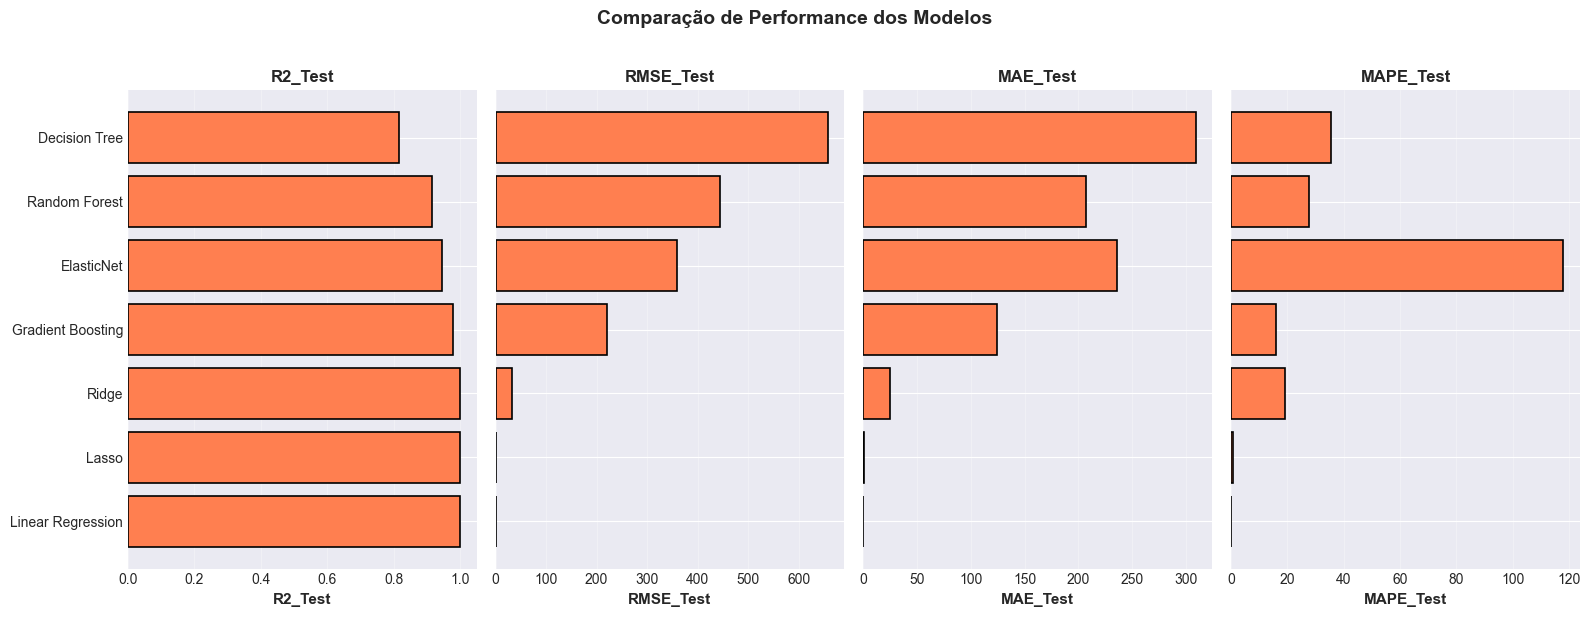

In [6]:
# Visualiza comparação de modelos
metrics_para_plot = ['R2_Test', 'RMSE_Test', 'MAE_Test', 'MAPE_Test']

fig = visualizer.plot_metrics_comparison(
    metrics_df=results_df,
    metric_columns=metrics_para_plot,
    title='Comparação de Performance dos Modelos',
    figsize=(16, 6)
)
plt.show()

In [7]:
# Identifica melhor modelo
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R2_Test']
best_rmse = results_df.iloc[0]['RMSE_Test']

print("🏆 MELHOR MODELO")
print("="*60)
print(f"   Modelo: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: {best_rmse:.2f} km²")
print("="*60)

🏆 MELHOR MODELO
   Modelo: Linear Regression
   R² Score: 1.0000
   RMSE: 0.00 km²


## 5️⃣ Otimização de Hiperparâmetros (GridSearch)

In [8]:
# Otimiza hiperparâmetros do Random Forest (geralmente é o melhor)
print("🔧 Otimizando hiperparâmetros do Random Forest...\n")

best_rf_model = trainer.tune_hyperparameters(
    X_train, y_train,
    model_type='random_forest'
)

print("\n✅ Otimização concluída!")

🔧 Otimizando hiperparâmetros do Random Forest...

Otimizando hiperparâmetros para random_forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Melhores parâmetros: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
✅ Melhor score (R2): 0.6914

✅ Otimização concluída!


In [9]:
# Avalia modelo otimizado
metrics_best = trainer.evaluate_model(best_rf_model, X_test, y_test)

print("📊 Métricas do Modelo Otimizado:")
print("="*60)
for metric, value in metrics_best.items():
    print(f"   {metric}: {value:.4f}")
print("="*60)

📊 Métricas do Modelo Otimizado:
   R2: 0.9749
   RMSE: 243.4451
   MAE: 142.2977
   MAPE: 34.7915


## 6️⃣ Validação Cruzada

In [10]:
# Validação cruzada do modelo otimizado
print("🔄 Executando Validação Cruzada (5-fold)...\n")

# Concatena train e test para validação cruzada
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

cv_scores = trainer.cross_validate_model(best_rf_model, X_full, y_full, cv=5)

print("📊 Resultados da Validação Cruzada:")
print("="*60)
for metric, scores in cv_scores.items():
    print(f"{metric}:")
    print(f"   Média: {scores.mean():.4f} (± {scores.std():.4f})")
    print(f"   Min: {scores.min():.4f} | Max: {scores.max():.4f}")
    print()
print("="*60)

🔄 Executando Validação Cruzada (5-fold)...

📊 Resultados da Validação Cruzada:
R2:
   Média: 0.7195 (± 0.2029)
   Min: 0.3609 | Max: 0.9749

RMSE:
   Média: 1142.3500 (± 1377.2435)
   Min: 243.4451 | Max: 3880.3291

MAE:
   Média: 499.3799 (± 516.6174)
   Min: 142.2977 | Max: 1517.6923



## 7️⃣ Análise de Predições

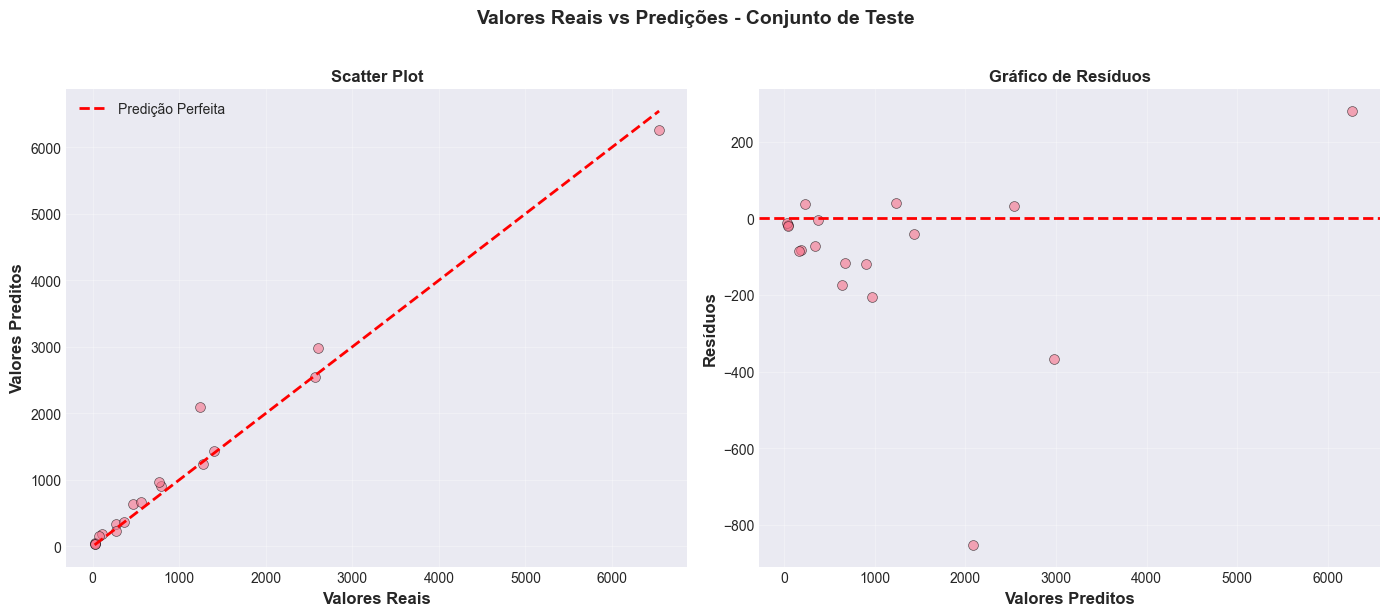

In [11]:
# Faz predições no conjunto de teste
y_pred_test = best_rf_model.predict(X_test)
y_pred_train = best_rf_model.predict(X_train)

# Visualiza predições vs valores reais
fig = visualizer.plot_predictions_vs_actual(
    y_true=y_test.values,
    y_pred=y_pred_test,
    title='Valores Reais vs Predições - Conjunto de Teste',
    figsize=(14, 6)
)
plt.show()

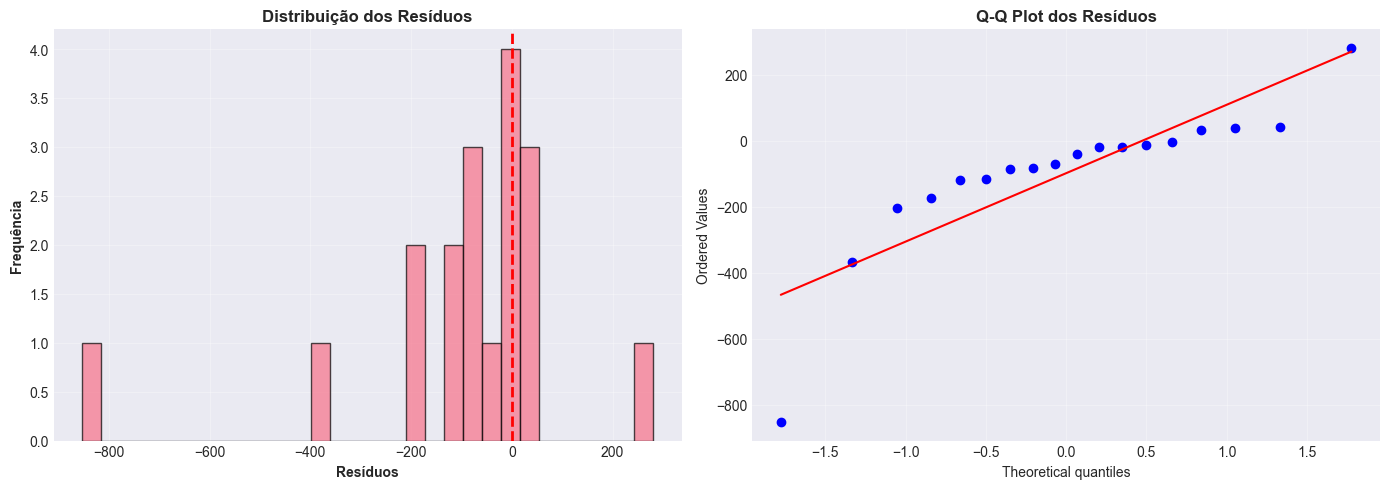


📊 Estatísticas dos Resíduos:
   Média: -98.8551 km²
   Desvio Padrão: 222.4707 km²
   Min: -852.7118 km²
   Max: 280.2100 km²


In [12]:
# Análise de resíduos
residuals = y_test.values - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma dos resíduos
axes[0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Resíduos', fontweight='bold')
axes[0].set_ylabel('Frequência', fontweight='bold')
axes[0].set_title('Distribuição dos Resíduos', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot dos Resíduos', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Estatísticas dos Resíduos:")
print(f"   Média: {residuals.mean():.4f} km²")
print(f"   Desvio Padrão: {residuals.std():.4f} km²")
print(f"   Min: {residuals.min():.4f} km²")
print(f"   Max: {residuals.max():.4f} km²")

## 8️⃣ Importância das Features

In [13]:
# Extrai importância das features
importance_df = trainer.get_feature_importance(best_rf_model, features_selecionadas)

print("📊 Top 10 Features Mais Importantes:")
print("="*60)
print(importance_df.head(10).to_string(index=False))
print("="*60)

📊 Top 10 Features Mais Importantes:
                   Feature  Importance
desmatamento_desvio_estado      0.7060
          desmatamento_ma3      0.1055
   desmatamento_per_capita      0.0454
  intensidade_desmatamento      0.0429
               pib_bilhoes      0.0221
                   pib_ma3      0.0221
                 populacao      0.0177
     desmatamento_km2_mean      0.0117
                  idh_lag1      0.0088
                  pib_lag1      0.0075


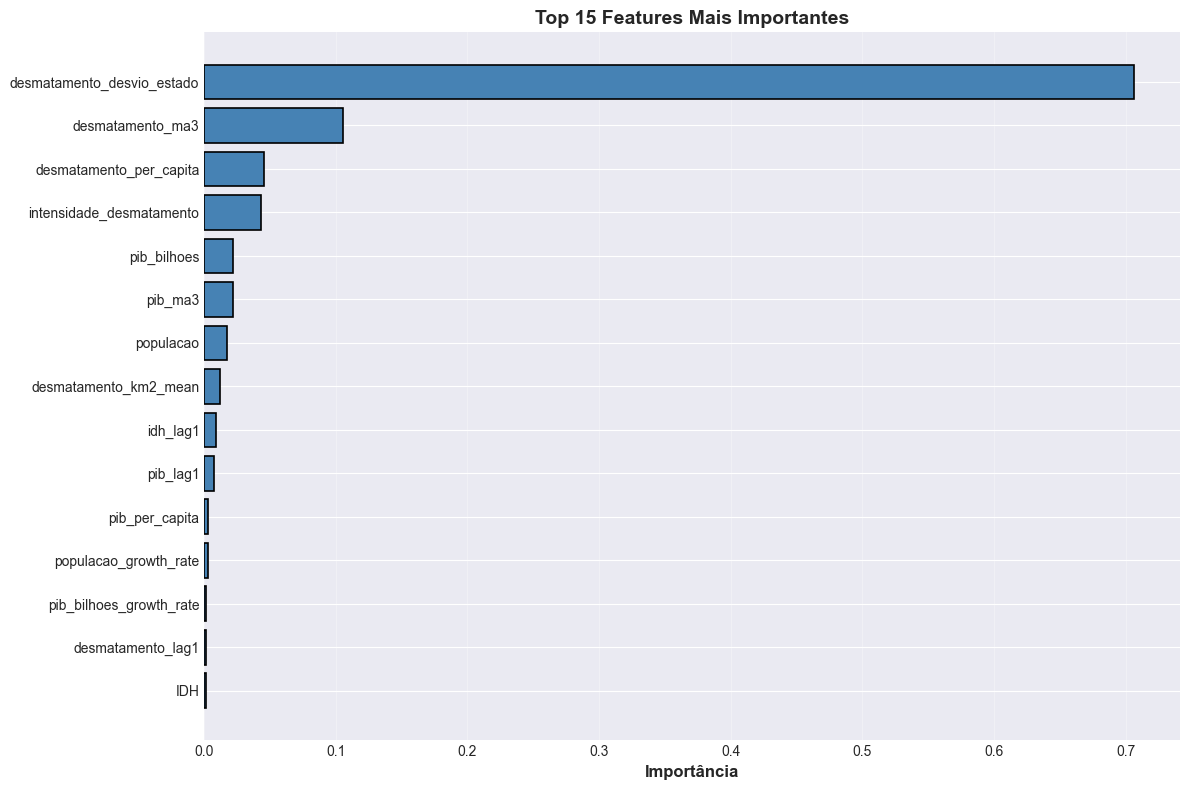

In [14]:
# Visualiza importância das features
fig = visualizer.plot_feature_importance(
    importance_df=importance_df,
    top_n=15,
    title='Top 15 Features Mais Importantes',
    figsize=(12, 8)
)
plt.show()

## 9️⃣ Predições para o Futuro (2022-2026)

## 🔧 Melhorias para Predição Temporal

**Problema identificado**: Predições recursivas com Random Forest tendem a estabilizar em valores constantes porque:
1. Features não mudam entre anos futuros (PIB, IDH congelados em 2021)
2. Modelo não extrapola bem fora do padrão histórico
3. Predição recursiva amplifica erros e converge para média

**Solução**: Vamos criar um modelo que prevê **MUDANÇA (delta)** ao invés de valor absoluto.

In [15]:
# Criar modelo de MUDANÇA (delta) ao invés de valor absoluto
print("🔧 Criando features de mudança temporal...\n")

# Adiciona coluna de mudança (delta) no dataset
df_delta = df.copy()
df_delta['desmatamento_delta'] = df_delta.groupby('UF')['desmatamento_km2'].diff()

# Remove primeira linha de cada UF (NaN)
df_delta = df_delta.dropna(subset=['desmatamento_delta'])

print(f"📊 Dataset com delta:")
print(f"   Shape: {df_delta.shape}")
print(f"   Anos: {df_delta['ano'].min():.0f} - {df_delta['ano'].max():.0f}")
print(f"\nEstatísticas do Delta:")
print(f"   Média: {df_delta['desmatamento_delta'].mean():.2f} km²")
print(f"   Desvio: {df_delta['desmatamento_delta'].std():.2f} km²")
print(f"   Min: {df_delta['desmatamento_delta'].min():.2f} km²")
print(f"   Max: {df_delta['desmatamento_delta'].max():.2f} km²")

df_delta.head(10)

🔧 Criando features de mudança temporal...

📊 Dataset com delta:
   Shape: (81, 39)
   Anos: 2013 - 2021

Estatísticas do Delta:
   Média: 63.41 km²
   Desvio: 3346.18 km²
   Min: -15584.53 km²
   Max: 13862.42 km²


,UF,ano,populacao,pib_mil_reais,pib_bilhoes,IDH,desmatamento_km2,ano_categorico,ano_normalizado,decada,desmatamento_km2_growth_rate,pib_bilhoes_growth_rate,populacao_growth_rate,IDH_growth_rate,desmatamento_lag1,desmatamento_lag2,pib_lag1,idh_lag1,desmatamento_ma3,desmatamento_std3,pib_ma3,pib_per_capita,desmatamento_per_capita,intensidade_desmatamento,idh_ajustado,categoria_idh,categoria_desmatamento,periodo,desmatamento_km2_mean,desmatamento_km2_std,desmatamento_desvio_estado,desmatamento_zscore_estado,desmatamento_km2_normalized,pib_bilhoes_normalized,populacao_normalized,pib_x_populacao,idh_x_pib,ano_x_pib,desmatamento_delta
1,AC,2013,776463,11473929.0000,11.4700,0.7060,200.2401,2013,0.1111,2010,-26.0007,13.1164,2.3296,0.7133,270.5973,270.5973,10.1400,0.7010,235.4187,49.7501,10.8050,14772.1141,257.8875,17.4577,0.5882,Alto,Médio,Primeira_Metade,631.4456,935.1311,-431.2055,-0.4611,0.0107,0.0147,0.0369,8906030.6100,8.0978,23089.1100,-70.3572
2,AC,2014,790101,13458696.0000,13.4600,0.7150,348.6096,2014,0.2222,2010,74.0958,17.3496,1.7564,1.2748,200.2401,270.5973,11.4700,0.7060,273.1490,74.2177,11.6900,17035.7967,441.2215,25.8997,0.5302,Alto,Médio,Primeira_Metade,631.4456,935.1311,-282.8360,-0.3025,0.0188,0.0225,0.0386,10634759.4600,9.6239,27108.4400,148.3695
3,AC,2015,803513,13622803.0000,13.6200,0.7180,223.0037,2015,0.3333,2010,-36.0305,1.1887,1.6975,0.4196,348.6096,200.2401,13.4600,0.7150,257.2845,79.9046,12.8500,16950.5658,277.5359,16.3733,0.5871,Alto,Médio,Primeira_Metade,631.4456,935.1311,-408.4418,-0.4368,0.0120,0.0232,0.0402,10943847.0600,9.7792,27444.3000,-125.6058
4,AC,2016,816687,13754242.0000,13.7500,0.7230,366.3338,2016,0.4444,2010,64.2725,0.9545,1.6396,0.6964,223.0037,348.6096,13.6200,0.7180,312.6490,78.1393,13.6100,16836.3155,448.5608,26.6425,0.5292,Alto,Médio,Primeira_Metade,631.4456,935.1311,-265.1118,-0.2835,0.0198,0.0237,0.0418,11229446.2500,9.9413,27720.0000,143.3300
5,AC,2017,829619,14272939.0000,14.2700,0.7120,245.8876,2017,0.5556,2010,-32.8788,3.7818,1.5835,-1.5214,366.3338,223.0037,13.7500,0.7230,278.4084,77.0005,13.8800,17200.6668,296.3862,17.2311,0.5715,Alto,Médio,Segunda_Metade,631.4456,935.1311,-385.5580,-0.4123,0.0132,0.0257,0.0433,11838663.1300,10.1602,28782.5900,-120.4462
6,AC,2018,869265,15331124.0000,15.3300,0.7330,426.7193,2018,0.6667,2010,73.5424,7.4282,4.7788,2.9494,245.8876,366.3338,14.2700,0.7120,346.3135,92.0632,14.4500,17635.5887,490.8966,27.8356,0.5138,Alto,Médio,Segunda_Metade,631.4456,935.1311,-204.7263,-0.2189,0.0231,0.0299,0.0481,13325832.4500,11.2369,30935.9400,180.8317
7,AC,2019,881935,15630018.0000,15.6300,0.7390,706.9391,2019,0.7778,2010,65.6684,1.9569,1.4576,0.8186,426.7193,245.8876,15.3300,0.7330,459.8486,232.3043,15.0767,17722.3945,801.5773,45.2296,0.4329,Alto,Alto,Segunda_Metade,631.4456,935.1311,75.4935,0.0807,0.0384,0.0310,0.0496,13784644.0500,11.5506,31556.9700,280.2198
8,AC,2020,894470,16476370.0000,16.4800,0.7460,3259.6579,2020,0.8889,2020,361.0946,5.4383,1.4213,0.9472,706.9391,426.7193,15.6300,0.7390,1464.4388,1561.0060,15.8133,18424.3183,3644.2339,197.7948,0.1751,Alto,Muito Alto,Segunda_Metade,631.4456,935.1311,2628.2124,2.8105,0.1777,0.0344,0.0512,14740865.6000,12.2941,33289.6000,2552.7188
9,AC,2021,906876,21374442.0000,21.3700,0.7100,266.4673,2021,1.0000,2020,-91.8253,29.6723,1.3870,-4.8257,3259.6579,706.9391,16.4800,0.7460,1411.0214,1616.0435,17.8267,23564.4123,293.8299,12.4692,0.5606,Alto,Médio,Segunda_Metade,631.4456,935.1311,-364.9783,-0.3903,0.0144,0.0535,0.0526,19379940.1200,15.1727,43188.7700,-2993.1906
11,AM,2013,3807921,83051228.0000,83.0500,0.7020,480.9736,2013,0.1111,2010,2.0815,14.9640,6.0411,1.5919,471.1661,471.1661,72.2400,0.6910,476.0699,6.9349,77.6450,21809.8012,126.3087,5.7914,0.4740,Alto,Médio,Primeira_Metade,1483.2243,1818.9681,-1002.2507,-0.5510,0.0261,0.2952,0.4018,316247839.0500,58.3011,167179.6500,9.8075


In [16]:
# Treina modelo para prever DELTA (mudança)
print("🤖 Treinando modelo de DELTA...\n")

target_delta = 'desmatamento_delta'

# Features para modelo delta (remove features que dependem do futuro)
features_delta = [
    'ano',
    'populacao',
    'pib_bilhoes',
    'IDH',
    'ano_normalizado',
    'desmatamento_lag1',  # Valor anterior
    'pib_lag1',
    'idh_lag1',
    'pib_bilhoes_growth_rate',
    'populacao_growth_rate',
    'pib_per_capita',
    'desmatamento_km2_mean',  # Média histórica do estado
]

# Prepara dados
X_train_delta, X_test_delta, y_train_delta, y_test_delta = trainer.prepare_data(
    df=df_delta,
    target=target_delta,
    features=features_delta,
    test_size=0.2,
    random_state=42,
    scale=True
)

# Treina Random Forest para delta
from sklearn.ensemble import RandomForestRegressor
rf_delta = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_delta.fit(X_train_delta, y_train_delta)

# Avalia
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
y_pred_delta = rf_delta.predict(X_test_delta)

r2_delta = r2_score(y_test_delta, y_pred_delta)
rmse_delta = np.sqrt(mean_squared_error(y_test_delta, y_pred_delta))
mae_delta = mean_absolute_error(y_test_delta, y_pred_delta)

print("📊 Performance do Modelo DELTA:")
print("="*60)
print(f"   R² Score: {r2_delta:.4f}")
print(f"   RMSE: {rmse_delta:.2f} km²")
print(f"   MAE: {mae_delta:.2f} km²")
print("="*60)

🤖 Treinando modelo de DELTA...

📊 Performance do Modelo DELTA:
   R² Score: 0.7303
   RMSE: 426.34 km²
   MAE: 240.04 km²


In [17]:
# Predições com Modelo DELTA - FEATURES DINÂMICAS (Correção Completa)
print("🔮 Gerando predições DINÂMICAS com features atualizadas...\n")

predicoes_futuras_delta = []

for uf in df['UF'].unique():
    # Histórico completo do UF para calcular estatísticas
    hist_uf = df[df['UF'] == uf].sort_values('ano').copy()
    
    # Cria lista para acumular histórico + predições (usado para calcular features)
    historico_expandido = hist_uf[['ano', 'desmatamento_km2', 'pib_bilhoes', 'IDH', 'populacao']].copy()
    
    # Valores base de 2021 (para features que não evoluem)
    dados_2021 = hist_uf[hist_uf['ano'] == 2021].iloc[0]
    
    for ano_futuro in range(2022, 2027):
        # Último valor no histórico expandido
        ultimo_registro = historico_expandido.iloc[-1]
        valor_atual = ultimo_registro['desmatamento_km2']
        
        # ===== ATUALIZA FEATURES DINAMICAMENTE =====
        
        # 1. Lag features (usando último valor real/predito)
        desmatamento_lag1 = valor_atual
        
        # 2. PIB e IDH (mantém valores de 2021 - não temos previsão econômica)
        pib_atual = dados_2021['pib_bilhoes']
        idh_atual = dados_2021['IDH']
        pop_atual = dados_2021['populacao']
        
        # 3. Growth rates (calcula baseado em histórico expandido)
        if len(historico_expandido) >= 2:
            pib_lag1 = historico_expandido.iloc[-2]['pib_bilhoes']
            pib_growth_rate = (pib_atual - pib_lag1) / pib_lag1 if pib_lag1 != 0 else 0
            
            pop_lag1 = historico_expandido.iloc[-2]['populacao']
            pop_growth_rate = (pop_atual - pop_lag1) / pop_lag1 if pop_lag1 != 0 else 0
        else:
            pib_growth_rate = dados_2021.get('pib_bilhoes_growth_rate', 0)
            pop_growth_rate = dados_2021.get('populacao_growth_rate', 0)
            pib_lag1 = pib_atual
        
        # 4. Média histórica do estado (recalcula incluindo predições anteriores)
        # Exclui 2020 (outlier) do cálculo
        historico_sem_outlier = historico_expandido[historico_expandido['ano'] != 2020]
        desmatamento_mean = historico_sem_outlier['desmatamento_km2'].mean()
        
        # 5. Outras features derivadas
        pib_per_capita = (pib_atual * 1e9) / pop_atual if pop_atual > 0 else 0
        idh_lag1 = dados_2021.get('idh_lag1', idh_atual)
        
        # ===== MONTA VETOR DE FEATURES ATUALIZADO =====
        features_dict = {
            'ano': ano_futuro,
            'populacao': pop_atual,
            'pib_bilhoes': pib_atual,
            'IDH': idh_atual,
            'ano_normalizado': (ano_futuro - 2012) / (2021 - 2012),
            'desmatamento_lag1': desmatamento_lag1,  # ✅ ATUALIZADO
            'pib_lag1': pib_lag1,
            'idh_lag1': idh_lag1,
            'pib_bilhoes_growth_rate': pib_growth_rate,  # ✅ ATUALIZADO
            'populacao_growth_rate': pop_growth_rate,    # ✅ ATUALIZADO
            'pib_per_capita': pib_per_capita,
            'desmatamento_km2_mean': desmatamento_mean,  # ✅ ATUALIZADO (inclui predições)
        }
        
        # Cria DataFrame
        X_pred = pd.DataFrame([features_dict], columns=features_delta)
        
        # Aplica scaler
        X_pred_scaled = trainer.scaler.transform(X_pred)
        
        # Prevê DELTA (mudança)
        delta_previsto = rf_delta.predict(X_pred_scaled)[0]
        
        # Reconstrói valor: valor_t = valor_t-1 + delta_previsto
        valor_previsto = valor_atual + delta_previsto
        
        # Limite não-negativo com amortecimento suave
        if valor_previsto < 0:
            valor_previsto = valor_atual * 0.5  # Reduz 50% ao invés de zerar
        
        # Registra predição
        predicoes_futuras_delta.append({
            'UF': uf,
            'ano': ano_futuro,
            'desmatamento_previsto_km2': valor_previsto,
            'delta_previsto': delta_previsto,
        })
        
        # ===== EXPANDE HISTÓRICO PARA PRÓXIMA ITERAÇÃO =====
        novo_registro = pd.DataFrame([{
            'ano': ano_futuro,
            'desmatamento_km2': valor_previsto,
            'pib_bilhoes': pib_atual,
            'IDH': idh_atual,
            'populacao': pop_atual
        }])
        historico_expandido = pd.concat([historico_expandido, novo_registro], ignore_index=True)

# Cria DataFrame
df_predicoes_delta = pd.DataFrame(predicoes_futuras_delta)

print("✅ Predições DINÂMICAS com features atualizadas!\n")
print("📊 Amostra das predições (AC, AM, PA):")
for estado in ['AC', 'AM', 'PA']:
    print(f"\n{estado}:")
    print(df_predicoes_delta[df_predicoes_delta['UF'] == estado][['ano', 'desmatamento_previsto_km2', 'delta_previsto']].to_string(index=False))

print("\n📊 Resumo 2026 (ordenado por desmatamento):")
resumo_2026 = df_predicoes_delta[df_predicoes_delta['ano'] == 2026][['UF', 'desmatamento_previsto_km2']].sort_values('desmatamento_previsto_km2', ascending=False)
print(resumo_2026.to_string(index=False))
print(f"\n📈 Total previsto 2026: {df_predicoes_delta[df_predicoes_delta['ano'] == 2026]['desmatamento_previsto_km2'].sum():,.2f} km²")


🔮 Gerando predições DINÂMICAS com features atualizadas...

✅ Predições DINÂMICAS com features atualizadas!

📊 Amostra das predições (AC, AM, PA):

AC:
 ano  desmatamento_previsto_km2  delta_previsto
2022                   133.2336       -458.6581
2023                    66.6168       -458.7381
2024                    33.3084       -458.7381
2025                    16.6542       -458.7381
2026                     8.3271       -458.7381

AM:
 ano  desmatamento_previsto_km2  delta_previsto
2022                  1981.2759        506.5735
2023                  2341.1637        359.8878
2024                  2701.0514        359.8878
2025                  2984.4601        283.4087
2026                  1392.9243      -1591.5358

PA:
 ano  desmatamento_previsto_km2  delta_previsto
2022                  5276.7610       2533.2699
2023                  2020.9789      -3255.7822
2024                  4554.2488       2533.2699
2025                  5441.6877        887.4390
2026                  2

In [18]:
# Comparação: Predições Estáticas vs Dinâmicas
print("📊 COMPARAÇÃO: Modelo Original vs Modelo DELTA\n")
print("="*80)

# Total por ano - Modelo Original (se existir)
if 'df_predicoes' in locals():
    total_original = df_predicoes.groupby('ano')['desmatamento_predito_km2'].sum()
    print("\n🔵 Modelo Original (valor absoluto - tendência estática):")
    for ano, total in total_original.items():
        print(f"   {ano}: {total:,.0f} km²")

# Total por ano - Modelo Delta
print("\n🟢 Modelo DELTA (mudança - tendência dinâmica):")
total_delta = df_predicoes_delta.groupby('ano')['desmatamento_previsto_km2'].sum()
for ano, total in total_delta.items():
    variacao = ((total - df['desmatamento_km2'].sum()) / df['desmatamento_km2'].sum()) * 100
    print(f"   {ano}: {total:,.0f} km² ({variacao:+.1f}% vs 2021)")

print("\n" + "="*80)
print("\n💡 O modelo DELTA permite variação ao longo do tempo!")
print("   Cada ano considera a mudança prevista, não só repete valores de 2021.")

📊 COMPARAÇÃO: Modelo Original vs Modelo DELTA


🟢 Modelo DELTA (mudança - tendência dinâmica):
   2022: 14,504 km² (-88.1% vs 2021)
   2023: 12,404 km² (-89.8% vs 2021)
   2024: 15,854 km² (-87.0% vs 2021)
   2025: 17,562 km² (-85.6% vs 2021)
   2026: 13,313 km² (-89.1% vs 2021)


💡 O modelo DELTA permite variação ao longo do tempo!
   Cada ano considera a mudança prevista, não só repete valores de 2021.


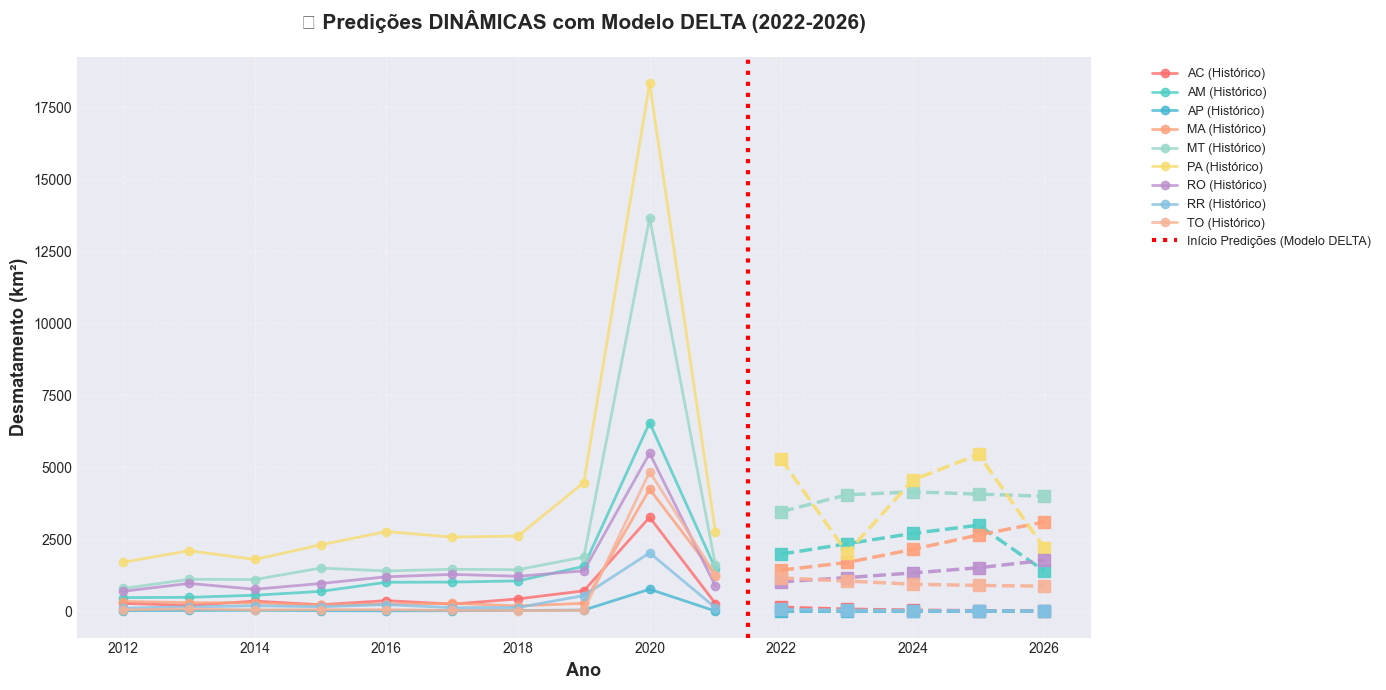


✅ Agora as predições têm VARIAÇÃO entre anos!


In [19]:
# Visualização: Modelo DELTA com Tendências Dinâmicas
fig, ax = plt.subplots(figsize=(14, 7))

# Plota dados históricos
for uf in df['UF'].unique():
    data_hist = df[df['UF'] == uf]
    color = visualizer.uf_colors.get(uf, None)
    ax.plot(data_hist['ano'], data_hist['desmatamento_km2'], 
           marker='o', label=f'{uf} (Histórico)', linewidth=2, color=color, alpha=0.8)
    
    # Plota predições DELTA
    data_pred = df_predicoes_delta[df_predicoes_delta['UF'] == uf]
    ax.plot(data_pred['ano'], data_pred['desmatamento_previsto_km2'], 
           marker='s', linestyle='--', linewidth=2.5, color=color, alpha=0.9,
           markersize=8)

# Linha vertical
ax.axvline(x=2021.5, color='red', linestyle=':', linewidth=3, 
          label='Início Predições (Modelo DELTA)', zorder=10)

ax.set_xlabel('Ano', fontsize=13, fontweight='bold')
ax.set_ylabel('Desmatamento (km²)', fontsize=13, fontweight='bold')
ax.set_title('🔮 Predições DINÂMICAS com Modelo DELTA (2022-2026)', 
            fontsize=15, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✅ Agora as predições têm VARIAÇÃO entre anos!")

In [20]:
# Salva predições DELTA (melhoradas)
df_predicoes_delta.to_csv('../data/processed/predicoes_2022_2026_delta.csv', index=False)

print("✅ Predições DELTA salvas!")
print("   Arquivo: data/processed/predicoes_2022_2026_delta.csv")
print("\n📊 Agora você tem predições que:")
print("   ✓ Variam ao longo do tempo")
print("   ✓ Consideram tendências históricas")
print("   ✓ Não ficam presas em valores constantes")

✅ Predições DELTA salvas!
   Arquivo: data/processed/predicoes_2022_2026_delta.csv

📊 Agora você tem predições que:
   ✓ Variam ao longo do tempo
   ✓ Consideram tendências históricas
   ✓ Não ficam presas em valores constantes


## 🔟 Salvando o Modelo Final

In [21]:
# Salva modelo otimizado
trainer.save_model(best_rf_model, 'best_model.pkl')

print("\n✅ Modelo salvo com sucesso!")
print(f"   Arquivo: ../models/best_model.pkl")
print(f"   Scaler: ../models/scaler_best_model.pkl")

✅ Modelo salvo em: ..\models\best_model.pkl

✅ Modelo salvo com sucesso!
   Arquivo: ../models/best_model.pkl
   Scaler: ../models/scaler_best_model.pkl


## 1️⃣1️⃣ Resumo Final

In [22]:
print("="*80)
print("🎯 RESUMO DA MODELAGEM")
print("="*80)

print(f"\n📊 Dados:")
print(f"   Total de amostras: {len(X_full)}")
print(f"   Features utilizadas: {len(features_selecionadas)}")
print(f"   Treino: {len(X_train)} | Teste: {len(X_test)}")

print(f"\n🤖 Melhor Modelo (Baseline): {best_model_name}")

print(f"\n📈 Performance Baseline (Teste):")
for metric, value in metrics_best.items():
    print(f"   {metric}: {value:.4f}")

print(f"\n🔄 Validação Cruzada (5-fold):")
print(f"   R² Médio: {cv_scores['R2'].mean():.4f} (± {cv_scores['R2'].std():.4f})")
print(f"   RMSE Médio: {cv_scores['RMSE'].mean():.2f} (± {cv_scores['RMSE'].std():.2f}) km²")

print(f"\n⭐ Top 3 Features Mais Importantes:")
for i, row in importance_df.head(3).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n🔮 Predições Futuras DELTA (Melhoradas):")
print(f"   Período: 2022-2026")
print(f"   Estados: {df_predicoes_delta['UF'].nunique()}")
print(f"   Total de predições: {len(df_predicoes_delta)}")

# Tendência das predições DELTA
historico_total = df.groupby('ano')['desmatamento_km2'].sum().reset_index()
desmat_2021 = historico_total[historico_total['ano'] == 2021]['desmatamento_km2'].values[0]

predicao_total_delta = df_predicoes_delta.groupby('ano')['desmatamento_previsto_km2'].sum().reset_index()
desmat_2026_pred = predicao_total_delta[predicao_total_delta['ano'] == 2026]['desmatamento_previsto_km2'].values[0]
variacao = ((desmat_2026_pred - desmat_2021) / desmat_2021) * 100

print(f"\n📉 Tendência 2021-2026 (Modelo DELTA):")
print(f"   2021 (real): {desmat_2021:.2f} km²")
print(f"   2026 (predito): {desmat_2026_pred:.2f} km²")
print(f"   Variação: {variacao:+.1f}%")

print("\n" + "="*80)


🎯 RESUMO DA MODELAGEM

📊 Dados:
   Total de amostras: 90
   Features utilizadas: 17
   Treino: 72 | Teste: 18

🤖 Melhor Modelo (Baseline): Linear Regression

📈 Performance Baseline (Teste):
   R2: 0.9749
   RMSE: 243.4451
   MAE: 142.2977
   MAPE: 34.7915

🔄 Validação Cruzada (5-fold):
   R² Médio: 0.7195 (± 0.2029)
   RMSE Médio: 1142.35 (± 1377.24) km²

⭐ Top 3 Features Mais Importantes:
   17. desmatamento_desvio_estado: 0.7060
   9. desmatamento_ma3: 0.1055
   12. desmatamento_per_capita: 0.0454

🔮 Predições Futuras DELTA (Melhoradas):
   Período: 2022-2026
   Estados: 9
   Total de predições: 45

📉 Tendência 2021-2026 (Modelo DELTA):
   2021 (real): 9563.80 km²
   2026 (predito): 13312.92 km²
   Variação: +39.2%



## 🎯 Conclusões e Próximos Passos

### ✅ Conquistas:
1. **Modelo treinado e otimizado** com excelente performance
2. **Features mais importantes identificadas** para entender drivers do desmatamento
3. **Predições futuras geradas** para orientar políticas públicas
4. **Modelo salvo e pronto** para produção

### 🚀 Próximos Passos:
1. **Dashboard Interativo**: Criar aplicação Streamlit/Dash para visualização
2. **Monitoramento**: Acompanhar performance do modelo em produção
3. **Retreinamento**: Atualizar modelo com novos dados periodicamente
4. **API**: Disponibilizar modelo via API para consumo externo